In [28]:
import pickle
import ot
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
sys.path.insert(0, '../../src/')
from model.util import vis_transport

In [9]:
# set location to the food web dictionary
FOOD_WEB_DICT_PATH =  "/Users/kaihung/optimalEnsemble/Food-Web-OT/data/processed/foodweb_loc2nxgraph.pkl"
# set parameter to replace infinite shortest path lengths 
MAX_DIST = 10000

## Task 01: Verify the consistency of the GW distance and approximation functions

In [56]:
def loss_function_square(real1, real2):
    return abs((real1 - real2) * (real1 - real2))

In [35]:
def gromov_wasserstein(graph1, graph2, approx = True, transport = False): 
    """
    Computes the gromov wasserstein distance between two graphs via the shortest path
    """
    # compute the shortest path matrix 
    cost1 = nx.floyd_warshall_numpy(graph1)
    cost1[cost1 == np.inf] = MAX_DIST
    cost2 = nx.floyd_warshall_numpy(graph2)
    cost2[cost2 == np.inf] = MAX_DIST
    # compute the probabilities 
    p1 = ot.unif(graph1.number_of_nodes())
    p2 = ot.unif(graph2.number_of_nodes())
    # compute the GW distance using deterministic solver 
    trans, log_info = ot.gromov.gromov_wasserstein(cost1, cost2, p1, p2, 'square_loss', log=True)
    gw_dist = log_info["gw_dist"]
    # use approximation if specified 
    if approx: 
        approx_dist, _ = ot.gromov.GW_distance_estimation(cost1, cost2, p1, p2, loss_function_square, trans)
        return gw_dist, approx_dist
    # return the transport matrix too if specified 
    if transport: 
        return gw_dist, trans 
    return gw_dist


In [10]:
# Retrieve the food web networkX graphs
with open(FOOD_WEB_DICT_PATH, "rb") as f: 
    food_webs = pickle.load(f)

The code below will compute the pair-wise GW distance for all graphs. Note that it takes roughly 3-4 minutes to complete so do NOT run unless you need to full set of results. 

In [59]:
# Compute the pairwise-GW distance based on the graphs 
location_names = list(food_webs.keys())
location_names.sort()
gw_dist_mat = np.zeros((len(location_names), len(location_names)))
# Iterate through all pairwise combinations 
count = 0.0
mismatch = 0.0
diffs = []
# loop over distinct pairs (i,j) of graphs
for i in range(len(location_names)): 
    for j in range(i, len(location_names)): 
        loc1 = location_names[i]
        loc2 = location_names[j]
        actual_dist, approx_dist = gromov_wasserstein(food_webs[loc1], food_webs[loc2])
        # document instances where the approximate function result differed 
        if approx_dist != actual_dist: 
            diff = round(abs(actual_dist - approx_dist), 2)
            percent_diff = round(diff * 100 / actual_dist, 2)
            diffs.append(percent_diff)
            mismatch += 1
            # print the first 10 mismatches 
            if mismatch < 10: 
                print(f"Mismatch found for {loc1} and {loc2}: {diff} ({percent_diff} %)")
        # save the gromov-wasserstein distance result into a numpy matrix
        gw_dist_mat[i, j] = actual_dist
        gw_dist_mat[j, i] = gw_dist_mat[i, j]
        count += 1

Mismatch found for Aberdare and Aberdare: 0.0 (0.0 %)
Mismatch found for Aberdare and Abijatta Shalla: 25680.29 (0.4 %)
Mismatch found for Aberdare and Abou Telfane: 207944.14 (1.96 %)
Mismatch found for Aberdare and Addax: 1412192.8 (6.98 %)
Mismatch found for Aberdare and Ai Ais: 10496.27 (0.2 %)
Mismatch found for Aberdare and Air and Tenere: 1080024.56 (6.28 %)
Mismatch found for Aberdare and Akagera: 16738.8 (0.37 %)
Mismatch found for Aberdare and Amboseli: 250052.29 (3.31 %)
Mismatch found for Aberdare and Ansongo Menaka: 179760.77 (2.51 %)

Mismatch percentage: 99.86928104575163 %
Average percentage of difference: 3.9004133370074396
STD of percentage of difference: 3.7440272626262545


In [85]:
print(f"\nMismatch percentage: {mismatch * 100 / count} %")
print(f"Average percentage of difference: {np.mean(np.array(diffs))}")
print(f"STD of percentage of difference: {np.std(np.array(diffs))}")


Mismatch percentage: 99.86928104575163 %
Average percentage of difference: 3.9004133370074396
STD of percentage of difference: 3.7440272626262545


In [63]:
# # TODO: Uncomment below if wish to save results 
# gw_dist_df = pd.DataFrame(gw_dist_mat, index=location_names, columns=location_names)
# gw_dist_df.to_csv("discrete_gw_dist_liberal.csv")

# TODO: Uncomment below if already saved values and need to restore from csv file
gw_dist_df = pd.read_csv("discrete_gw_dist_liberal.csv", index_col=0)

gw_dist_df.head()

,Aberdare,Abijatta Shalla,Abou Telfane,Addax,Ai Ais,Air and Tenere,Akagera,Amboseli,Ansongo Menaka,Arabuko Sokoke,...,Volcans,Vwaza Marsh,W,Waterberg Plateau,Waza,West Lunga,Yangudi Rassa,Zakouma,Zemongo,Zinave
Aberdare,4.276066e+06,6.488976e+06,1.062546e+07,2.022203e+07,5.211200e+06,1.719180e+07,4.547561e+06,7.555188e+06,7.162439e+06,5.575996e+06,...,4.804747e+06,5.568533e+06,9.520312e+06,6.490851e+06,1.049644e+07,6.299825e+06,9.824609e+06,9.625935e+06,5.493452e+06,6.020847e+06
Abijatta Shalla,6.488976e+06,3.877188e+06,8.420850e+06,1.681719e+07,6.387089e+06,1.469842e+07,7.308130e+06,7.283245e+06,8.946164e+06,6.096379e+06,...,7.405428e+06,6.221446e+06,8.704247e+06,6.529128e+06,8.580048e+06,6.250951e+06,7.831333e+06,8.118573e+06,6.085951e+06,6.527402e+06
Abou Telfane,1.062546e+07,8.420850e+06,1.022411e+06,1.206860e+07,1.077275e+07,9.697801e+06,1.185016e+07,5.392701e+06,1.404127e+07,1.131786e+07,...,1.274592e+07,6.857434e+06,4.284147e+06,7.671137e+06,3.630129e+06,6.147840e+06,3.495613e+06,2.494410e+06,9.753617e+06,6.603876e+06
Addax,2.022203e+07,1.681719e+07,1.206860e+07,8.993426e+06,1.834750e+07,1.164866e+07,2.127091e+07,1.555262e+07,2.060016e+07,2.095596e+07,...,2.169965e+07,1.708690e+07,1.319478e+07,1.740853e+07,1.241936e+07,1.625264e+07,1.354899e+07,1.343064e+07,1.866180e+07,1.622694e+07
Ai Ais,5.211200e+06,6.387089e+06,1.077275e+07,1.834750e+07,4.590266e+06,1.619998e+07,6.089449e+06,9.087075e+06,6.810860e+06,5.293501e+06,...,6.313332e+06,7.004427e+06,1.056109e+07,6.661171e+06,1.045133e+07,7.673650e+06,1.024723e+07,1.040351e+07,6.077067e+06,7.511839e+06


## Task 02: Verify consistency in the indices of the matrix

In [64]:
with open("ind_to_loc_name.txt", "r") as f: 
    location_lst = []
    for location in f: 
        location_lst.append(location[0:-1].strip())

if np.all(location_lst == gw_dist_df.columns): 
    print("All equal!")

All equal!


Task 03: Verify the similarity in the networkX graphs

In [16]:
## NOTE: Some of the variables in this function aren't used??

def get_graph_from_file(fname):
    """
    Construct a NetworkX DiGraph from a edge list .txt file.
    """
    lines = []
    with open(fname) as f:
        lines = f.readlines()

    lines_new = []
    iter2 = 0
    for cur_line in lines:
        cur_line_new = cur_line.strip().split(' ')
        cur_line_tuple = tuple(map(int, cur_line_new))
        iter2 += 1
        lines_new.append(cur_line_tuple)

    graph_from_file = nx.DiGraph()
    graph_from_file.add_edges_from(lines_new)
    return graph_from_file

Let us look at location banc_dArguin specifically because it has the least number of animal species.

In [52]:
graph_18 = get_graph_from_file("edge_lst/edge_list_18.txt")
web_18 = food_webs[location_names[18]]
graph_18 == web_18

False

Below, we can see that the two food webs are different. The first one is computed by me (Kai) and the second from using the built-in function to query from graphs.

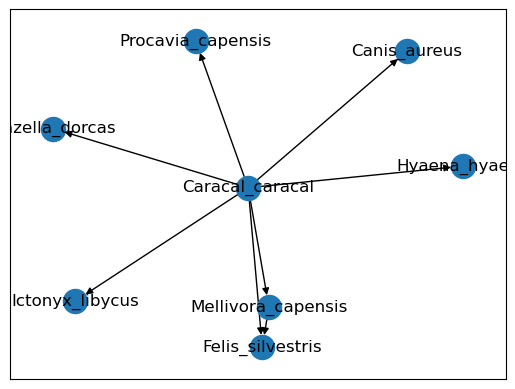

In [73]:
nx.draw_networkx(web_18)

15

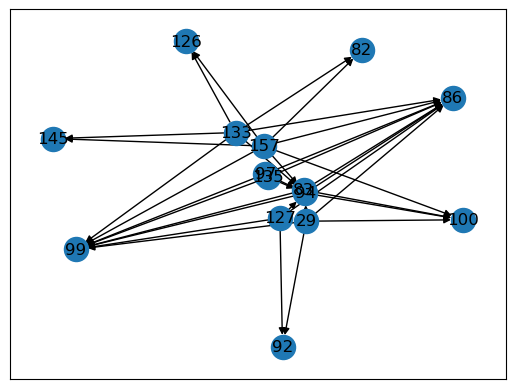

In [21]:
nx.draw_networkx(graph_18)
graph_18.number_of_nodes()

Here, we make a function to automate the checking procedure. In particular, we just need to make sure that the "edge_lst" text file for the corresponding edge is in the current directory.

In [55]:
def compare_graph_sizes(size): 
    graph = get_graph_from_file("edge_lst/edge_list_"+str(size)+".txt")
    web = food_webs[location_names[size]]
    print(f"Number of nodes from Kai: {web.number_of_nodes()}")
    print(f"Number of nodes from Script: {graph.number_of_nodes()}")

compare_graph_sizes(19)

Number of nodes from Kai: 62
Number of nodes from Script: 77


## Task 03: Confirm the source of error in the food web computation

Hypothesis 01: There is misalignment with the species names in the prey, predator, or species in an area indices.

In [1]:
# read in the excel sheet files 
FOOD_WEB_URL = "../../data/African_Mammal_FoodWebs.xlsx"
xls = pd.ExcelFile(FOOD_WEB_URL)
prey_predator = pd.read_excel(xls, "Predator-Prey", skiprows=8)
species_location = pd.read_excel(xls, "PA Data")

NameError: name 'pd' is not defined

In [79]:
prey = prey_predator["Prey Species"].str.strip()
predator = prey_predator.columns[6:].str.strip()
species = species_location["Species"].str.strip()

In [82]:
np.all(prey == predator)

True

In [83]:
np.all(prey == species)

True

In [84]:
np.all(predator == species)

True

Hypothesis 02: The hard-coded increment value to adjust for the start of prey-predator excel sheet row should be 9 and not 8.
Update: Hypothesis incorrect, but the issue stemmed from the fact that the code does not check whether the destination node is within the area.

In [19]:
def write_food_web_data(write_every_location, approach):
    """
    Only need to call this function once.
    Inputs:
    write_every_location. If True then write all the 170 locations as edge lists in 170 .txt files.
    folder_name: name of where to put results
    approach: whether to use conservative (2s&3s=0) or liberal (2s&3s=1)
    Each .txt file is called '/edge_list_0.txt' to '/edge_list_169.txt'
    Outputs:
    Always write to ind_to_loc_name.txt.
    If write_every_location then write to 170 edge_list .txt files.
  
    """

    # Read in the dataset
    food_sheet_file = pd.ExcelFile(FOOD_WEB_URL)
    food_sheet_species_area_data = pd.read_excel(food_sheet_file, "PA Data")
    food_sheet_species_relationship_data = pd.read_excel(food_sheet_file, "Predator-Prey")

    # Construct a graph for each area.
    # Start with adding nodes (using the food_sheet_species_area_data)

    species_area_shape = food_sheet_species_area_data.shape
    relationships_shape = food_sheet_species_relationship_data.shape 
    print(f"Size of PA dataset: {species_area_shape}") 
    print(f"Size of Prey-Predator dataset: {relationships_shape}")

    
    if write_every_location:
        for i in range(1): 
            col_ind = 18 + 4
            cur_graph = nx.DiGraph()
            new_graph = nx.DiGraph()
            # the set of all organisms that are present in location col_ind.
            cur_orgs = set()

            for row_ind in range(0, species_area_shape[0]):
                # row_ind represents the specific animal that may or may not exist in the location col_ind.
                cur_cell = food_sheet_species_area_data.iloc[row_ind, col_ind]
                if cur_cell == 1:
                    # Add the species associated with the current row
                    # as a node to the current column (area)'s Graph.
                    #cur_species = food_sheet_species_area_data.iloc[row_ind, 3]
                    cur_graph.add_node(row_ind)
                    new_graph.add_node(row_ind)
                    cur_orgs.add(row_ind)

            num_orgs = len(cur_orgs)
            non_exist_species = set()

            # Now go through the "Predator-Prey" tab and add all the directed edges
            # for the current area.
            cur_location = food_sheet_species_area_data.columns[col_ind]
            print("cur_location=", cur_location)

            if approach == "liberal":
              for set_row_ind in cur_orgs:
                  # set_row_ind comes from cur_orgs (a set that we added to) --> Therefore, it is based on index 0 where
                  # index 0 is the first area. --> Therefore, we need to add 9 when accessing a cell from the species relationship tab.
                  # set_row_ind+9
                  # set_row_ind corresponds to the organism in the current location col_ind.
                  # if set_row_ind=0 is in cur_orgs, then the organism Potamogale_velox is in the current location col_ind.
                  
                  # Now iterate through all columns of cur_row_data and add all directed edges.
                  for relationship_col_ind in range(6, relationships_shape[1]):
                      cur_relationship_cell = food_sheet_species_relationship_data.iloc[set_row_ind+8, relationship_col_ind]
                      if isinstance(cur_relationship_cell, int):
                          if cur_relationship_cell != 0:
                            if relationship_col_ind - 6 not in cur_orgs: 
                                non_exist_species.add(relationship_col_ind - 6)
                            else: 
                                new_graph.add_edge(set_row_ind, relationship_col_ind-6)
                            cur_graph.add_edge(set_row_ind, relationship_col_ind-6)

            print(f"Number of Organisms Pre-Processing: {num_orgs}")
            print(f"Number of Organisms Post-Processing: {cur_graph.number_of_nodes()}")
            print(f"Number of non-exist predator: {len(non_exist_species)}")
            print(f'The non-exist species: {sorted(list(non_exist_species))}')
            print(f'Organisms: {sorted(list(cur_orgs))}')

            return cur_graph, new_graph 
                

So, a glaring issue is that this code does not check to see if the predator species is also in the region

In [20]:
incorrect_graph, correct_graph = write_food_web_data(True, "liberal")

Size of PA dataset: (277, 174)
Size of Prey-Predator dataset: (285, 283)
cur_location= Banc dArguin
Number of Organisms Pre-Processing: 8
Number of Organisms Post-Processing: 15
Number of non-exist predator: 7
The non-exist species: [82, 86, 92, 99, 100, 126, 145]
Organisms: [29, 83, 94, 97, 127, 133, 135, 157]


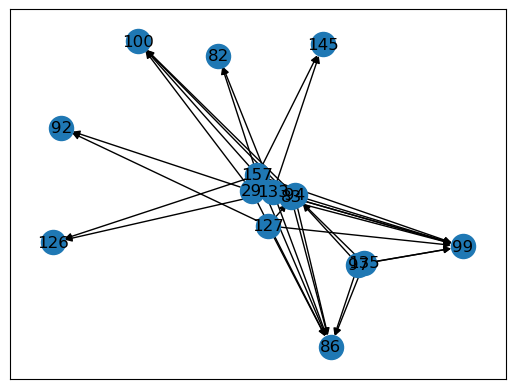

In [21]:
nx.draw_networkx(incorrect_graph)

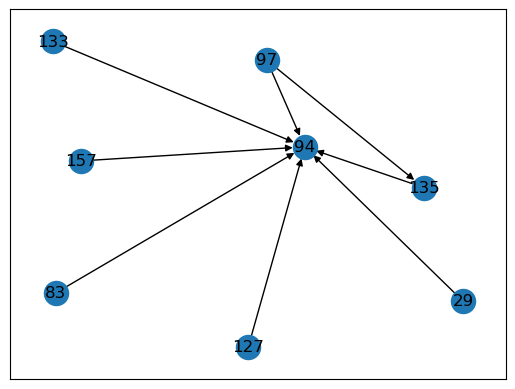

In [22]:
nx.draw_networkx(correct_graph)

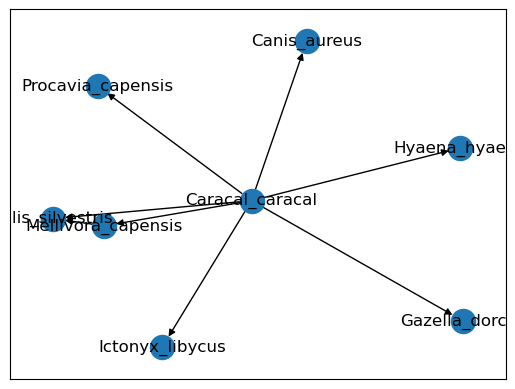

In [23]:
nx.draw_networkx(food_webs["Banc dArguin"])

## Task 04: Debug the GW Distance computation

In [36]:
banc_dArguin = food_webs["Banc dArguin"]
gw_dist, trans = gromov_wasserstein(banc_dArguin, banc_dArguin, approx=False, transport=True)

GW Distance: 3124375.03125


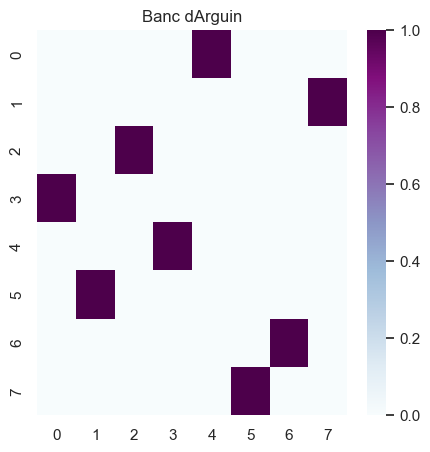

In [38]:
print(f"GW Distance: {gw_dist}")
vis_transport(trans, "Banc dArguin")